# Distinguibilidade de estados 

Existem algumas medidas para se distinguir dois estados quânticos $\hat{\rho}$ e $\hat{\sigma}$, sejam eles estados puros ou misturas estatíticas. Há medidas baseadas em normas e entropias e em medidas geométricas. 

<b>Numericamente</b>, a maneira de calcular essas medidas consiste em diagonalizar $\hat{\rho}$ e $\hat{\sigma}$ (ou sua diferença, produtos) e trabalhar diretamente com os autovalores e autovetores. 
Note que, no cálculo da entropia relativa, pode ocorrer que as bases em que $\hat{\rho}$ e $\hat{\sigma}$ são diagonais não é a mesma. 

O QuTip já têm essas funções prontas, então podemos usá-las diretamente. 

A seguir, vamos recapitular as definições das métricas discutidas em sala de aula e apontar a respectiva função no qutip.

Na categoria entropias e normas: 

## Entropia de von Neumann
$$
S(\hat{\rho}) = - \text{Tr}[\hat{\rho} \log{\hat{\rho}}]
$$


QuTip:
```python
entropy_vn(rho, base=e)
```

## Entropia relativa
$$
S(\hat{\rho}|| \hat{\sigma}) = \text{Tr}[\hat{\rho} \log{\hat{\rho}} - \hat{\rho} \log{\hat{\sigma}}]
$$


QuTip:
```python
entropy_relative(rho, sigma)
```

## Distância traço
$$
D(\hat{\rho}, \hat{\sigma}) = \frac{1}{2} || \hat{\rho} - \hat{\sigma}||_1 = \frac{1}{2} \text{Tr}(|\hat{\rho} - \hat{\sigma}|)
$$


QuTip:
```python
tracedist(rho, sigma)
```

## Fidelidade
$$
F(\hat{\rho}, \hat{\sigma})  = ||\sqrt{\hat{\rho}} \sqrt{\hat{\sigma}}||_1 = 
\text{Tr}[\sqrt{\sqrt{\hat{\rho}} \hat{\sigma} \sqrt{\hat{\rho}}}]
$$

QuTip:
```python
fidelity(rho, sigma)
```

## Afinidade
$$
A(\hat{\rho}, \hat{\sigma}) = \text{Tr}[\sqrt{\hat{\rho}} \sqrt{\hat{\sigma}}]
$$

Não tem pronta no QuTip. Mas, podemos aproveitar o código fonte para a fidelidade e escrever nossa própria função. Note que as primeiras partes só garantem a compatibilidade entre os argumentos com os objetos do QuTip. 

```python
def affinity(rho, sigma):
    
    if rho.isket or rho.isbra:
        if sigma.isket or sigma.isbra:
            # The affinity for pure states reduces to the modulus of their inner product and coincides with the fidelity.
            return qutip.fidelity(rho, sigma)
            # Take advantage of the fact that the density operator for rho is a projector to avoid a sqrtm call.
        sqrtm_rho = qutip.ket2dm(rho).sqrtm()
    else:
        if sigma.isket or sigma.isbra:
            # Swap the order so that we can take a more numerically stable square root of sigma.
            return affinity(sigma, rho)
        # If we made it here, both rho and sigma are operators, so we have to take the sqrtm of one of them.
        sqrtm_rho = rho.sqrtm()
        sqrtm_sigma = sigma.sqrtm()

    if sqrtm_rho.dims != sqrtm_sigma.dims:
        raise TypeError('Density matrices do not have same dimensions.')

    # Using the eigenvalues of the matriz to evaluate the affinity
    eig_vals = (sqrtm_rho * sqrtm_sigma).eigenenergies()
    A = float(np.real((eig_vals[eig_vals > 0]).sum()))
    return A
    
```


Na categoria geométrica:
## Distância de Bures 
$$
D_B(\hat{\rho}, \hat{\sigma}) = 2 (1-F(\hat{\rho}, \hat{\sigma}))
$$

QuTip:
```python
bures_dist(rho, sigma)
```

### Ângulo de Bures
$$
\alpha_B(\hat{\rho}, \hat{\sigma}) = \arccos{F(\hat{\rho}, \hat{\sigma})}
$$

QuTip:
```python
bures_angle(rho, sigma)
```


## Distância de Hellinger
$$
D_H( \hat{\rho}, \hat{\sigma}) = (\text{Tr}[\sqrt{\hat{\rho}}-\sqrt{\hat{\sigma}}])^2
$$


QuTip:
```python
hellinger_dist(rho, sigma)
```

### Ângulo de Hellinger
$$
\alpha_H(\hat{\rho}, \hat{\sigma}) = \arccos{A(\hat{\rho}, \hat{\sigma})}
$$

Não tem pronta no Qutip, mas podemos aproveitar o código fonte para definir a função:
```python
def hellinger_angle(rho, sigma):
    if rho.isket or rho.isbra:
        rho = ket2dm(rho)
    if rho.isket or rho.isbra:
        sigma = ket2dm(sigma)

    if rho.dims != rho.dims:
        raise TypeError('rho and sigma do not have same dimensions.')

    return np.arccos(hellinger_dist(rho, sigma))
    
```

In [103]:
# definindo as novas funções 
import qutip
import numpy as np
def affinity(rho, sigma):
    if rho.isket or rho.isbra:
        if sigma.isket or sigma.isbra:
            # The affinity for pure states reduces to the modulus of their inner product and coincides with the fidelity.
            return qutip.fidelity(rho, sigma)
            # Take advantage of the fact that the density operator for rho is a projector to avoid a sqrtm call.
        sqrtm_rho = qutip.ket2dm(rho).sqrtm()
    else:
        if sigma.isket or sigma.isbra:
            # Swap the order so that we can take a more numerically stable square root of sigma.
            return affinity(sigma, rho)
        # If we made it here, both rho and sigma are operators, so we have to take the sqrtm of one of them.
        sqrtm_rho = rho.sqrtm()
        sqrtm_sigma = sigma.sqrtm()

    if sqrtm_rho.dims != sqrtm_sigma.dims:
        raise TypeError('Density matrices do not have same dimensions.')

    # Using the eigenvalues of the matriz to evaluate the affinity
    eig_vals = (sqrtm_rho * sqrtm_sigma).eigenenergies()
    return float(np.real((eig_vals[eig_vals > 0]).sum()))



def hellinger_angle(rho, sigma):
    if rho.isket or rho.isbra:
        rho = qutip.ket2dm(rho)
    if rho.isket or rho.isbra:
        sigma = qutip.ket2dm(sigma)

    if rho.dims != rho.dims:
        raise TypeError('rho and sigma do not have same dimensions.')

    return np.arccos(affinity(rho, sigma))


In [2]:
%matplotlib notebook

# Exemplos

## Estados de um qubit na esfera de Bloch

O estado de um qubit, puro ou misto, pode ser escrito em termos de um vetor $\mathbf{r}$ na esfera de Bloch 
$$
\begin{align*}
\hat{\rho} = \frac{1}{2}\left( \mathbb{I} + \mathbf{r}.\boldsymbol{\sigma}\right)
\end{align*}
$$
onde $\mathbf{r} = (r_x, r_y, r_z)$, com $r = \sqrt{r_x^2 + r_y^2 + r_z^2}$, e $\boldsymbol{\sigma} = (\hat{\sigma}_x, \hat{\sigma}_y, \hat{\sigma}_z)$ são as matrizes de Pauli.

Na forma matricial 

$$
\begin{align*}
\hat{\rho} = \frac{1}{2}\begin{pmatrix} 
1 + r_z & r_x -i r_y \\
r_x + i r_y & 1 - r_z
\end{pmatrix}
\end{align*}.
$$

Para ilustrar, vamos analisar o caso de dois vetores 

$$r_1 = (\frac{1}{2},0,\frac{\sqrt{3}}{2}) $$

$$ r_2 = (\frac{3}{2}, \frac{1}{\sqrt{8}}, \frac{1}{\sqrt{8}}) $$


já normalizados.

Vamos começar plotando esses dois vetores na esfera de Bloch. No Qutip existem objetos chamados ```python qutip.Bloch``` e ```python qutip.Bloch3d``` para mostrar os vetores de Bloch. OBS: a segunda função tem problemas para rodar inline em jupyter notebooks.



In [68]:
r1 = 1/2 * np.array([1, 0, np.sqrt(3)])
r2 = 1/np.sqrt(8) * np.array([np.sqrt(6),1, 1])

# veja que eles já estão normalizados
print(np.linalg.norm(r1))
print(np.linalg.norm(r2))

0.9999999999999999
0.9999999999999998


<IPython.core.display.Javascript object>


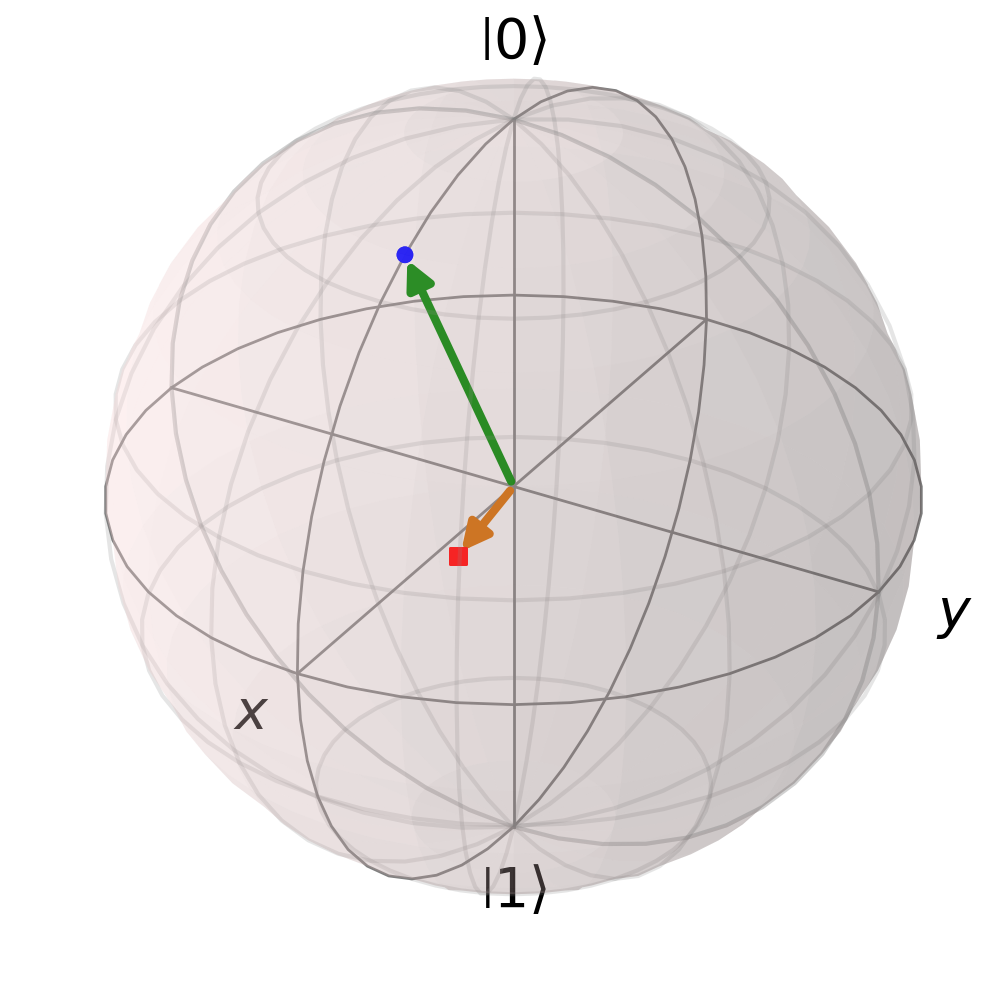

<IPython.core.display.Javascript object>


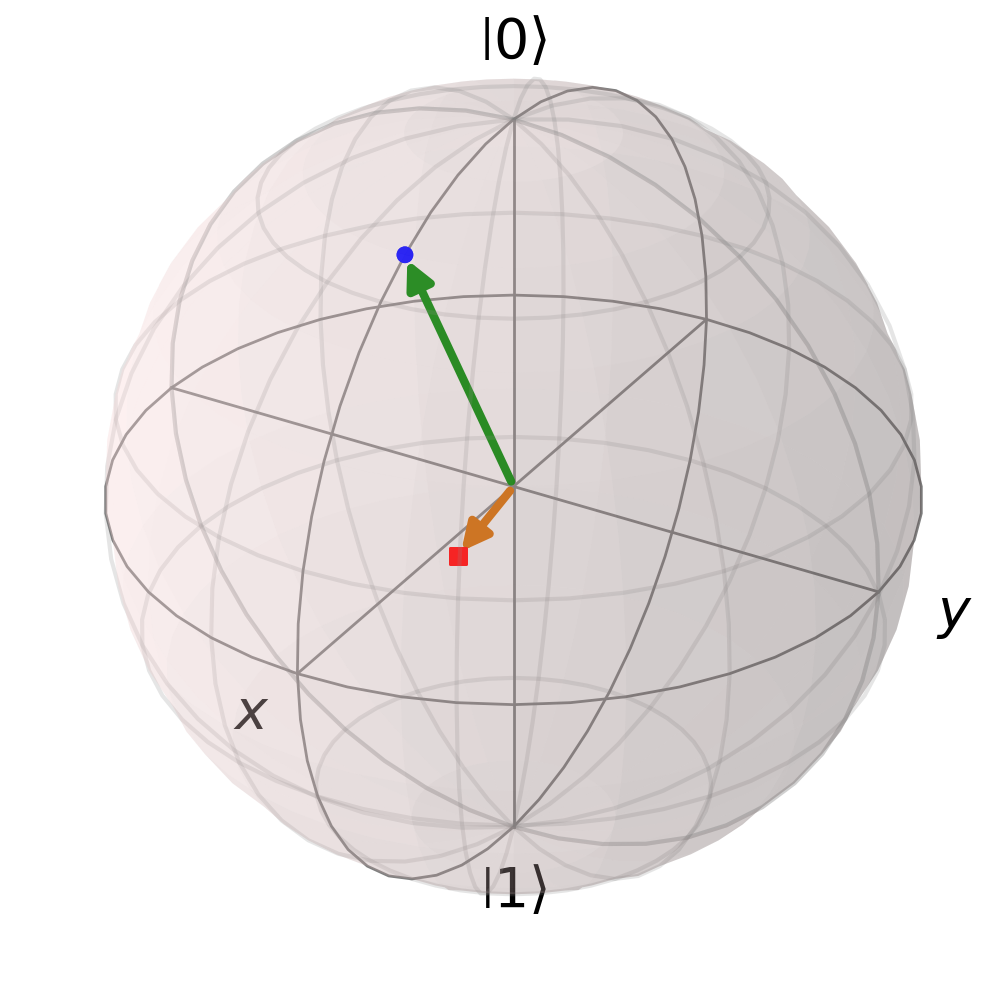

In [69]:
# esfera de Bloch
b = qutip.Bloch()
b.add_points(r1)
b.add_vectors(r1)
b.add_points(r2)
b.add_vectors(r2)
b.render()
b.show()


Agora, vamos para esses dois vetores, calcular as medidas de distinguibilidade.


In [70]:
# definindo os estados
si = qutip.identity(2)
sx = qutip.sigmax()
sy = qutip.sigmay()
sz = qutip.sigmaz()

s_vector = np.array([sx, sy, sz]).reshape(3,2,2)

def qubit_state_from_Bloch_vector(r_vector: np.array):
    rho = 1/2 * (si + r_vector[0] * sx + r_vector[1] * sy + r_vector[2] * sz)
    return rho


In [71]:
rho_1 = qubit_state_from_Bloch_vector(r1)
print(rho_1, rho_1.tr(), flush=True)
rho_2 = qubit_state_from_Bloch_vector(r2)
print(rho_2, rho_2.tr(), flush=True)


# von Neumann
S1 = qutip.entropy_vn(rho_1)
S2 = qutip.entropy_vn(rho_2)

print('\n', flush=True)
print('S(rho_1): ', S1)
print('S(rho_2): ', S2)



# entropia relativa
S12 = qutip.entropy_relative(rho_1, rho_2)
S21 = qutip.entropy_relative(rho_2, rho_1)

print('\n', flush=True)
print('S(rho_1|| rho_2): ', S12)
print('S(rho_2|| rho_1): ', S21)


Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[0.9330127 0.25     ]
 [0.25      0.0669873]] 1.0
Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[0.6767767+0.j        0.4330127-0.1767767j]
 [0.4330127+0.1767767j 0.3232233+0.j       ]] 1.0


S(rho_1):  1.0880786128001414e-15
S(rho_2):  2.8650923743559804e-15


S(rho_1|| rho_2):  inf
S(rho_2|| rho_1):  inf


Esses estados são puros!
Qual serão? Vejamos seus autovalores e autovetores


In [92]:
l1, v1 = rho_1.eigenstates()
l2, v2 = rho_2.eigenstates()

print('auto valores de rho_1: ')
print(l1[0])
print(v1[0].full())
print(l1[1])
print(v1[1].full())

print('\n')
print('auto valores de rho_2: ')
print(l2[0])
print(v2[0].full())
print(l2[1])
print(v2[1].full())



auto valores de rho_1: 
1.9626155733547187e-17
[[-0.25881905+0.j]
 [ 0.96592583+0.j]]
0.9999999999999997
[[0.96592583+0.j]
 [0.25881905+0.j]]


auto valores de rho_2: 
7.722665286123586e-17
[[-0.52635401+0.21488313j]
 [ 0.82266439+0.j        ]]
1.0
[[0.82266439+0.j        ]
 [0.52635401+0.21488313j]]
False


Vejamos o ângulo entre os vetores

$$ \cos{\theta_{12}} = \frac{\mathbf{r}. \mathbf{s}}{rs}$$

In [82]:
# os vetores ja sao normalizados!
cos12 = r1 @ r2
print(cos12)

0.7391989197401165


In [105]:

# distância traço
D12 = qutip.tracedist(rho_1, rho_2)
D21 = qutip.tracedist(rho_2, rho_1)

print('\n', flush=True)
print('D(rho_1,rho_2): ', D12)
print('D(rho_2,rho_1): ', D21)
print('distancia da diferenca r1,r2:',1/2 * np.linalg.norm(r1-r2))

# Hilbert-Schmidt
DHS12 = qutip.hilbert_dist(rho_1, rho_2)
DHS21 = qutip.hilbert_dist(rho_2, rho_1)

print('\n', flush=True)
print('D_HS(rho_1,rho_2): ', DHS12)
print('D_HS(rho_2,rho_1): ', DHS21)


# Fidelidade
F12 = qutip.fidelity(rho_1, rho_2)
F21 = qutip.fidelity(rho_2, rho_1)

print('\n', flush=True)
print('F(rho_1,rho_2): ', F12)
print('F(rho_2,rho_1): ', F21)
print('fidelidade do angulo:', np.sqrt(1/2 * (1+cos12)))

# Afinidade
A12 = affinity(rho_1, rho_2)
A21 = affinity(rho_2, rho_1)

print('\n', flush=True)
print('A(rho_1,rho_2): ', A12)
print('A(rho_2,rho_1): ', A21)
print('afinidade de r1, r2', (1 + cos12) / 2)



# Distância de Bures
Bd12 = qutip.bures_dist(rho_1, rho_2)
Bd21 = qutip.bures_dist(rho_2, rho_1)
# ângulo de Bures
Ba12 = qutip.bures_angle(rho_1, rho_2)
Ba21 = qutip.bures_angle(rho_2, rho_1)

print('\n', flush=True)
print('Bd(rho_1,rho_2): ', Bd12)
print('Bd(rho_2,rho_1): ', Bd21)

print('\n', flush=True)
print('Ba(rho_1,rho_2): ', Ba12)
print('Ba(rho_2,rho_1): ', Ba21)


# Distância de Hellinger
Hd12 = qutip.hellinger_dist(rho_1, rho_2)
Hd21 = qutip.hellinger_dist(rho_2, rho_1)
# ângulo de Hellinger
Ha12 = hellinger_angle(rho_1, rho_2)
Ha21 = hellinger_angle(rho_2, rho_1)

print('\n', flush=True)
print('Hd(rho_1,rho_2): ', Hd12)
print('Hd(rho_2,rho_1): ', Hd21)

print('\n', flush=True)
print('Ha(rho_1,rho_2): ', Ha12)
print('Ha(rho_2,rho_1): ', Ha21)





D(rho_1,rho_2):  0.36111014958034854
D(rho_2,rho_1):  0.36111014958034854
distancia da diferenca r1,r2: 0.36111014958034854


D_HS(rho_1,rho_2):  0.26080108025988336
D_HS(rho_2,rho_1):  0.26080108025988336


F(rho_1,rho_2):  0.932523168543312
F(rho_2,rho_1):  0.9325231685433122
fidelidade do angulo: 0.932523168543312


A(rho_1,rho_2):  0.8695994615936942
A(rho_2,rho_1):  0.8695994615936943
afinidade de r1, r2 0.8695994598700583


Bd(rho_1,rho_2):  0.3673603992176839
Bd(rho_2,rho_1):  0.36736039921768326


Ba(rho_1,rho_2):  0.36945809879299757
Ba(rho_2,rho_1):  0.36945809879299696


Hd(rho_1,rho_2):  0.5106868676719734
Hd(rho_2,rho_1):  0.5106868676719731


Ha(rho_1,rho_2):  0.5164057908325879
Ha(rho_2,rho_1):  0.5164057908325878


## Comparando diferentes protocolos de preparação e evolução de qubits

Vamos considerar, novamente, o caso em que que gostaríamos de preparar nosso qubit no estado $|0\rangle$, mas não deu, e existe uma probabilidade de encontrarmos o estado $|1\rangle$. Em uma primeira preparação $\hat{\rho}_1(0)$, essa probabilidade foi $\epsilon_1$ e numa segunda $\hat{\rho}_2(0)$ foi $\epsilon_2$. Gostaríamos de deixar os qubits evoluir de acordo com $\hat{H}_1 = J \hat{\sigma}_x$. Mas, na segunda preparação, alune de IC esqueceu de apertar um botão, e acabou ativando um outro protocolo sem querer. Nesse protocolo, o estado inicial (seja $|0\rangle$ ou $|1\rangle$) roda na direção $\hat{x}$ de $\pi/2$ , e liga um pequeno campo magnético $h$ na direção $\hat{z}$, constante durante todo o experimento. Então, $\hat{H}_2 = \hat{H}_1 + h \hat{\sigma}_z$. 

Queremos saber quão diferente vai ser o estado evoluído de cada um do estado inicial e quão distantes são  $\hat{\rho}_1(t)$ e $\hat{\rho}_2(t)$. No limite $h \rightarrow 0$ devemos ver que as medidas invariantes sob transformação unitária permanecem constantes e, por conseguinte, teremos $M(\hat{\rho}_1(0), \hat{\rho}_2(0)) = M(\hat{\rho}_1(t), \hat{\rho}_2(t)) \quad \forall t$, com $M$ sendo quaisquer das medidas de distinguibilidade.